In [24]:
%load_ext autoreload
%autoreload 2

import random
import sys
from pathlib import Path

base_path = Path().resolve().parent
sys.path.append(str(base_path))

import numpy as np
import sklearn
import torch
from loguru import logger

from src.data import DataLoader, DataPreprocessor, FeatureEngineer, StrokeDataset
from sklearn.model_selection import train_test_split
from src.models import LogisticRegression, evaluate
from src.visualization import DataExplorer, ResultsExplorer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
# set device to best available computational unit
device = None
if torch.cuda.is_available():
    print("Using Cuda")
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    print("Using Apple Silicon")
    device = torch.device("mps")
else:
    print("Using CPU")
    device = torch.device("cpu")

Using Apple Silicon


In [5]:
# get cli args
use_dependencies = "use-dependencies" in sys.argv
visualize_data = "skip-visualization" not in sys.argv
log_level = (
    sys.argv[sys.argv.index("--log-level") + 1] if "--log-level" in sys.argv else "INFO"
)
path_data_train = (
    sys.argv[sys.argv.index("--path-data-train") + 1]
    if "--path-data-train" in sys.argv
    else "data/raw/train.csv"
)
path_data_test = (
    sys.argv[sys.argv.index("--path-data-test") + 1]
    if "--path-data-test" in sys.argv
    else "data/raw/test.csv"  #
)

# set seeds
seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)
torch.manual_seed(seed_value)
sklearn.utils.check_random_state(seed_value)

# configure logging
# logger.remove(0)
# logger.add(sys.stderr, level=log_level.upper())

# log config vars
logger.info(f"log-level: {log_level.upper()}")
logger.info(f"visualize-data: {visualize_data}")
logger.info(f"use-dependencies: {use_dependencies}")
logger.info(f"path-data-train: {path_data_train}")
logger.info(f"path-data-test: {path_data_test}\n")

2024-06-18 15:04:51.782 | INFO     | __main__:<module>:30 - log-level: INFO
2024-06-18 15:04:51.783 | INFO     | __main__:<module>:31 - visualize-data: True
2024-06-18 15:04:51.783 | INFO     | __main__:<module>:32 - use-dependencies: False
2024-06-18 15:04:51.783 | INFO     | __main__:<module>:33 - path-data-train: data/raw/train.csv
2024-06-18 15:04:51.783 | INFO     | __main__:<module>:34 - path-data-test: data/raw/test.csv



In [6]:
# load data
data_loader = DataLoader()

data_train_raw = data_loader.load_data(base_path / path_data_train)
data_test_raw = data_loader.load_data(
    base_path / path_data_test
)  # no target given in test set

2024-06-18 15:04:54.806 | SUCCESS  | src.data.data_loader:load_data:14 - Successfully created Pandas Dataframe from raw data.

2024-06-18 15:04:54.809 | SUCCESS  | src.data.data_loader:load_data:14 - Successfully created Pandas Dataframe from raw data.



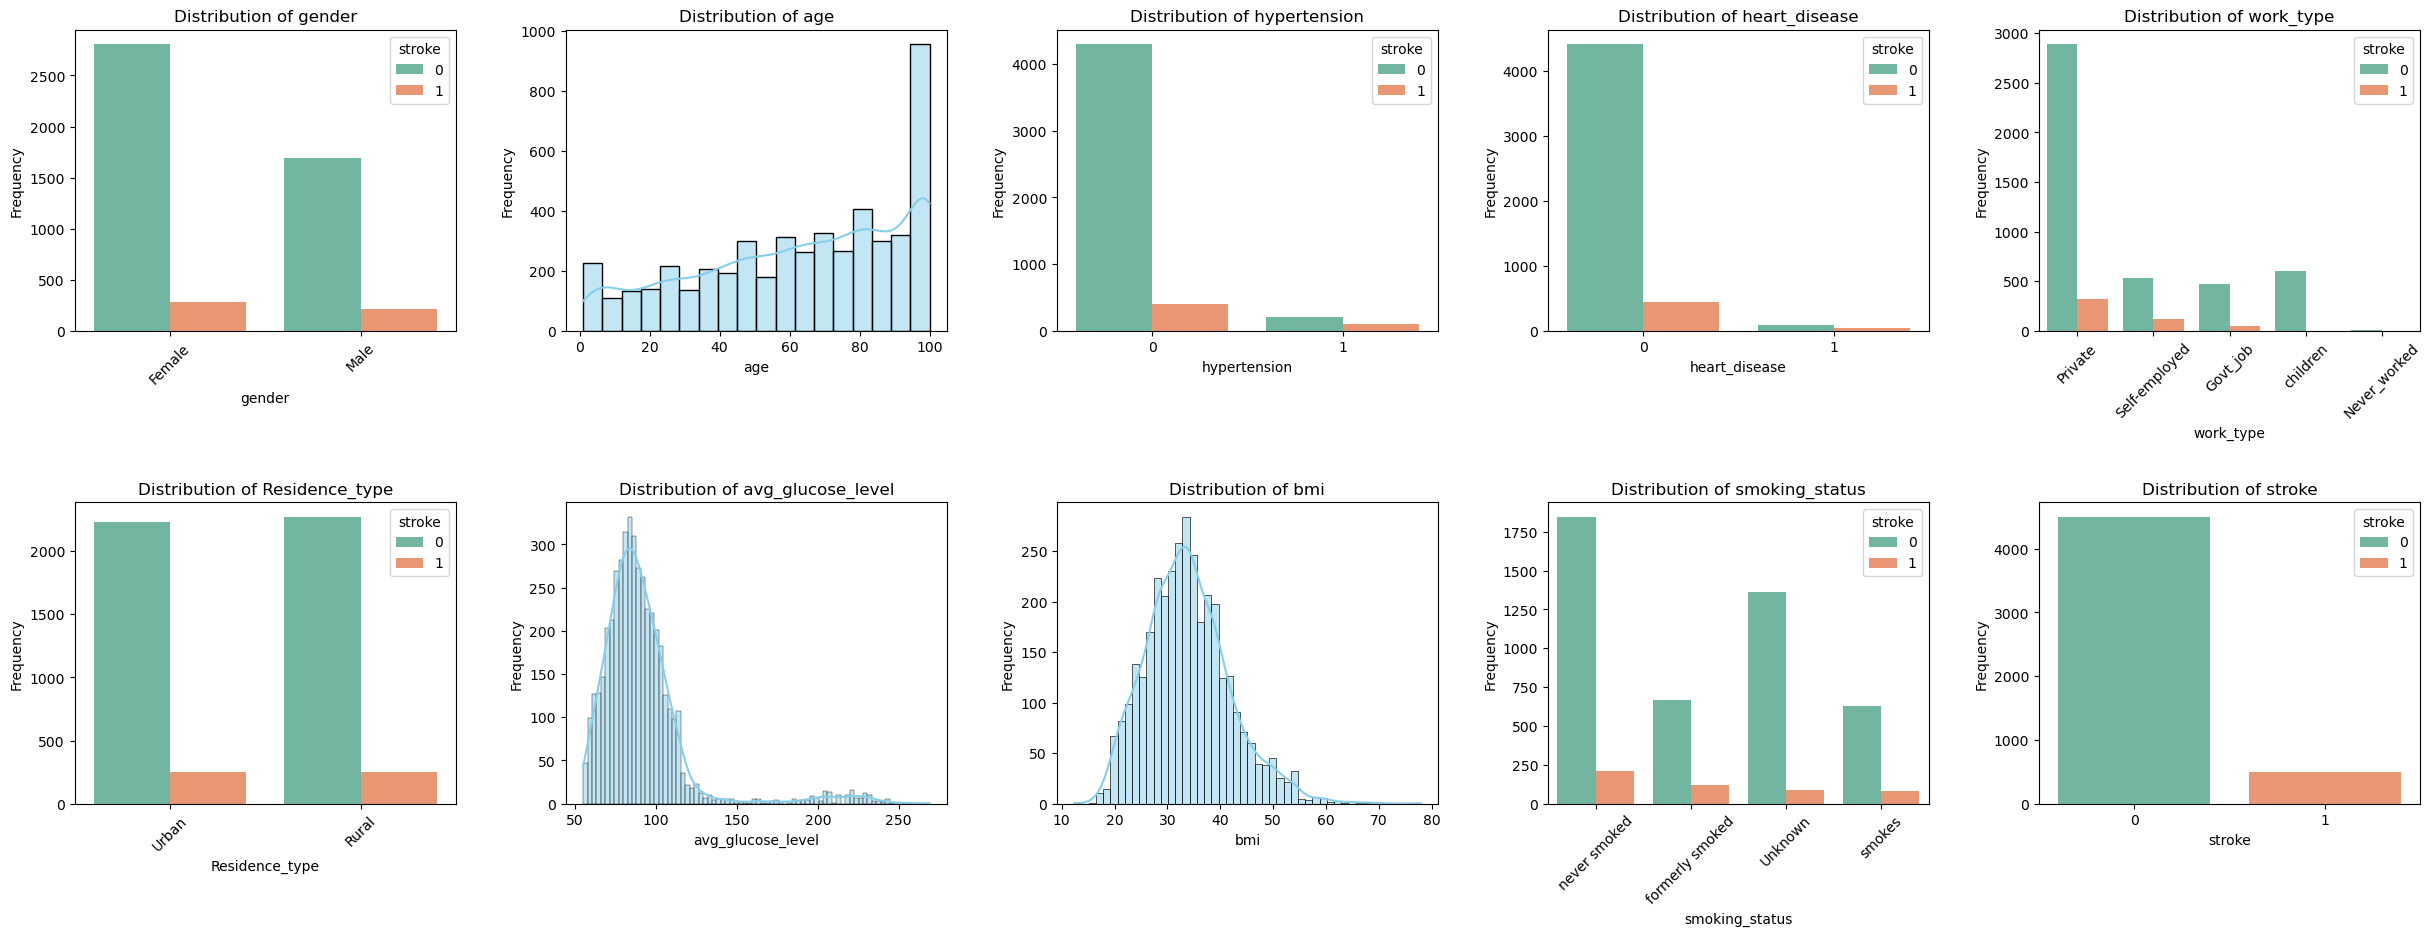

2024-06-18 15:04:57.159 | INFO     | src.visualization.data_explorer:plot_nans:61 - Number of NaN values in column id: 0 / 5000
2024-06-18 15:04:57.163 | INFO     | src.visualization.data_explorer:plot_nans:61 - Number of NaN values in column gender: 0 / 5000
2024-06-18 15:04:57.163 | INFO     | src.visualization.data_explorer:plot_nans:61 - Number of NaN values in column age: 0 / 5000
2024-06-18 15:04:57.164 | INFO     | src.visualization.data_explorer:plot_nans:61 - Number of NaN values in column hypertension: 0 / 5000
2024-06-18 15:04:57.164 | INFO     | src.visualization.data_explorer:plot_nans:61 - Number of NaN values in column heart_disease: 0 / 5000
2024-06-18 15:04:57.165 | INFO     | src.visualization.data_explorer:plot_nans:61 - Number of NaN values in column work_type: 0 / 5000
2024-06-18 15:04:57.166 | INFO     | src.visualization.data_explorer:plot_nans:61 - Number of NaN values in column Residence_type: 0 / 5000
2024-06-18 15:04:57.167 | INFO     | src.visualization.data

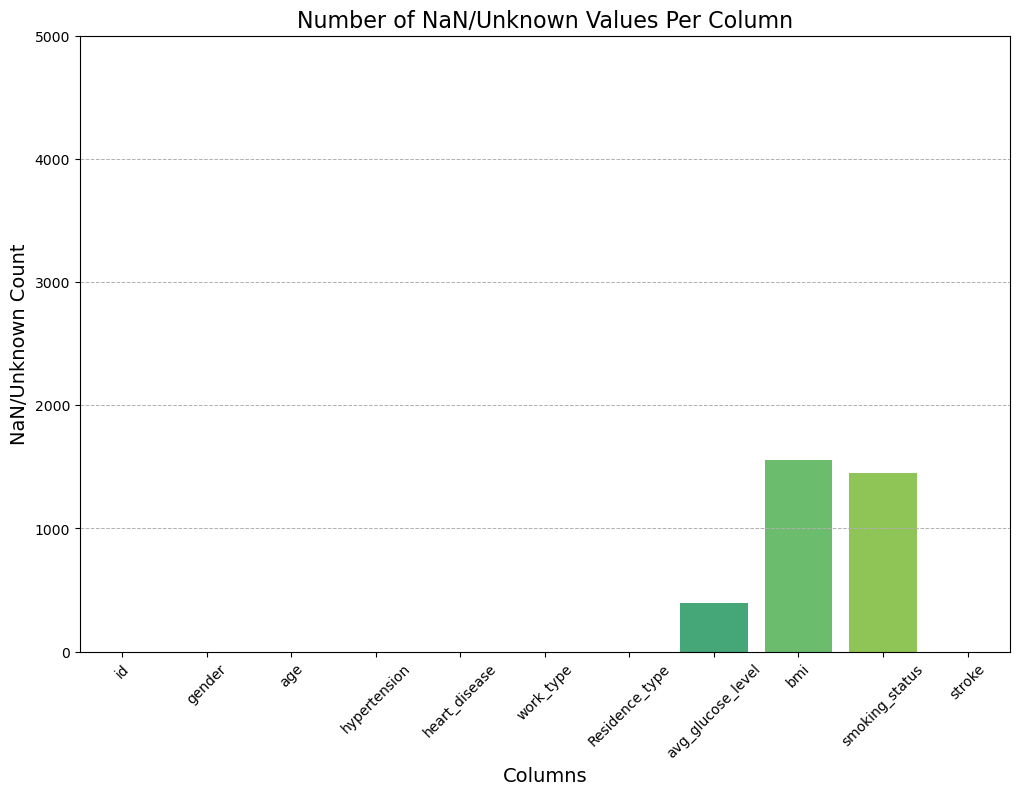

In [7]:
# visualize raw data
if visualize_data:
    data_explorer = DataExplorer()
    data_explorer.plot_distributions(data_train_raw)
    data_explorer.plot_nans(data_train_raw)
    # data_explorer.print_non_numericals(data_train_raw)

In [8]:
# preprocess data
data_preprocessor = DataPreprocessor()
data_train_preprocessed = data_preprocessor.transform_non_numericals(data_train_raw)
data_test_preprocessed = data_preprocessor.transform_non_numericals(data_test_raw)
# data_train_preprocessed = data_preprocessor.remove_nans(data_train_raw)

2024-06-18 15:05:02.625 | INFO     | src.data.data_preprocessor:transform_non_numericals:30 - Transformed gender into binary encoding
2024-06-18 15:05:02.627 | INFO     | src.data.data_preprocessor:transform_non_numericals:34 - Transformed work_type into one-hot encoding
2024-06-18 15:05:02.628 | INFO     | src.data.data_preprocessor:transform_non_numericals:30 - Transformed Residence_type into binary encoding
2024-06-18 15:05:02.630 | INFO     | src.data.data_preprocessor:transform_non_numericals:34 - Transformed smoking_status into one-hot encoding
2024-06-18 15:05:02.631 | INFO     | src.data.data_preprocessor:transform_non_numericals:30 - Transformed gender into binary encoding
2024-06-18 15:05:02.632 | INFO     | src.data.data_preprocessor:transform_non_numericals:34 - Transformed work_type into one-hot encoding
2024-06-18 15:05:02.633 | INFO     | src.data.data_preprocessor:transform_non_numericals:30 - Transformed Residence_type into binary encoding
2024-06-18 15:05:02.634 | INF

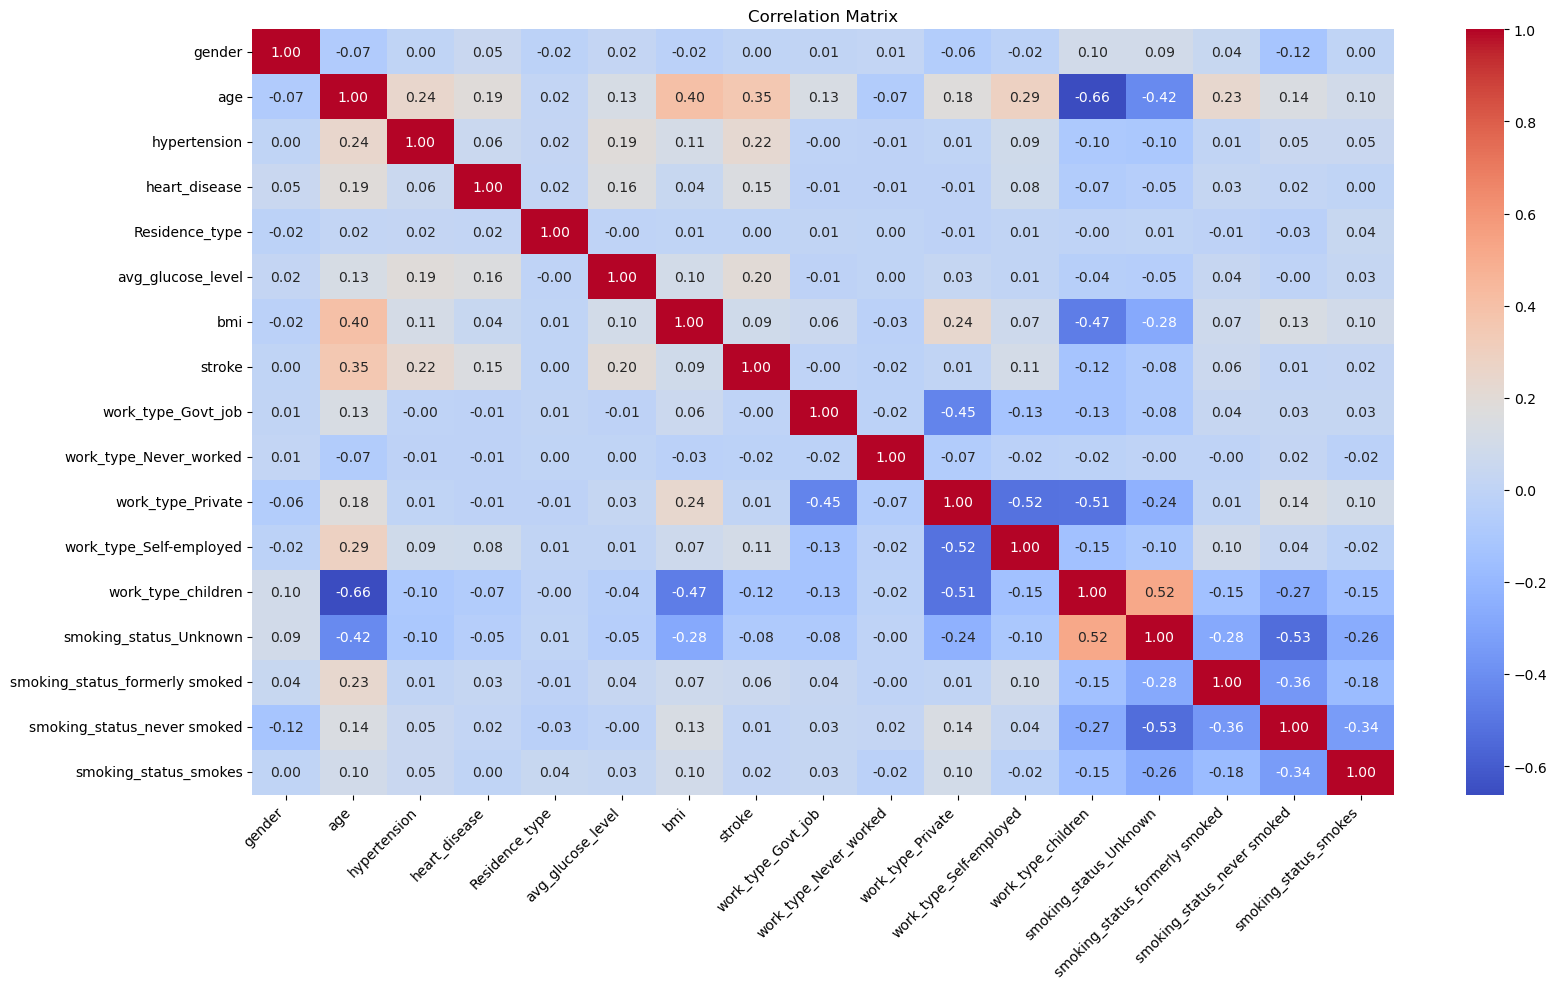

In [9]:
# feature exploration & engineering
feature_engineer = FeatureEngineer(data_train_preprocessed)
data_train_engineered = feature_engineer.drop(
    data_train_preprocessed,
    [
        "id",
        # "Residence_type",
        # "work_type_Private",
        # "work_type_Govt_job",
        # "work_type_Never_worked",
        # "smoking_status_never smoked",
        # "smoking_status_smokes",
        # "smoking_status_Unknown",
    ],
)
data_train_engineered = feature_engineer.dropna(data_train_engineered)
data_train_engineered = feature_engineer.normalize_features(data_train_engineered)

# data_train_engineered = feature_engineer.combine_features(
#     data_train_engineered,
#     [["age", "bmi"], ["age", "hypertension"]],
#     "multiplicative",
# )
if visualize_data:
    data_explorer.plot_correlation_matrix(data_train_engineered)
# data_test_engineered = feature_engineer.apply_transformations(data_test_preprocessed)

class_weights tensor([0.5564, 4.9319])
Epoch: 0. Train Loss: 0.7288987658917904. Val Loss: 0.7433935776352882. Accuracy: 71.29337539432177
Epoch: 1. Train Loss: 0.7184880319982767. Val Loss: 0.7326659351587296. Accuracy: 64.35331230283911
Epoch: 2. Train Loss: 0.7143195826560259. Val Loss: 0.724321362376213. Accuracy: 53.62776025236593
Epoch: 3. Train Loss: 0.7081524774432182. Val Loss: 0.717656534910202. Accuracy: 48.26498422712934
Epoch: 4. Train Loss: 0.6987852912396193. Val Loss: 0.7124085128307343. Accuracy: 47.63406940063091
Epoch: 5. Train Loss: 0.6985646251589059. Val Loss: 0.7076624274253845. Accuracy: 46.68769716088328
Epoch: 6. Train Loss: 0.6910425171256065. Val Loss: 0.703667163848877. Accuracy: 46.056782334384856
Epoch: 7. Train Loss: 0.6935349017381668. Val Loss: 0.6997452944517135. Accuracy: 46.37223974763407
Epoch: 8. Train Loss: 0.6920337378978729. Val Loss: 0.6961458563804627. Accuracy: 45.110410094637224
Epoch: 9. Train Loss: 0.6808323185890913. Val Loss: 0.69300292

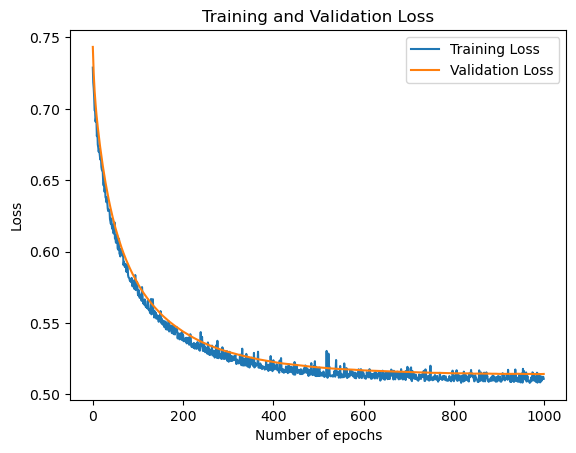

2024-06-18 16:09:49.802 | INFO     | src.models.evaluate:evaluate:27 - Logistic Regression – Accuracy: 0.7176656151419558, F1 score: 0.4013377926421405, Precision: 0.2608695652173913, Recall: 0.8695652173913043, AUC: 0.875593176862896
2024-06-18 16:09:49.804 | INFO     | src.models.evaluate:evaluate:30 - number of pos preds: [230]


[0.7735833  0.3329691  0.34730822 0.49591637 0.23248842 0.25857133
 0.26700404 0.35693052 0.5511129  0.5983809  0.4459174  0.5174675
 0.4719253  0.3324568  0.20457174 0.54753613 0.41508096 0.10770472
 0.6693776  0.37966767 0.12797968 0.39284095 0.41034713 0.35898012
 0.19585574 0.09461024 0.21438436 0.10985572 0.50087893 0.49410748
 0.4023375  0.4192968  0.4855094  0.52124405 0.6937023  0.28953773
 0.6167298  0.42744264 0.4835004  0.54032123 0.3839218  0.10500324
 0.6150657  0.7696291  0.3520392  0.6235086  0.13432601 0.551376
 0.5698792  0.5772465  0.4718206  0.70138675 0.43535304 0.49277446
 0.6289492  0.42922968 0.5720115  0.66969573 0.18995298 0.24462083
 0.18819927 0.6306141  0.4287057  0.2704811  0.69719505 0.47673336
 0.26318213 0.2514362  0.6624936  0.23696707 0.83367425 0.69605136
 0.43642595 0.57006085 0.10074798 0.28230587 0.21623078 0.27122885
 0.4882302  0.4618959  0.6350775  0.29640102 0.12100988 0.33436796
 0.36245248 0.63638884 0.8312452  0.43085048 0.31795976 0.5336422

In [63]:
X_train, y_train = feature_engineer.split_X_y(data_train_engineered)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

dataset_train = StrokeDataset(X_train, y_train)
dataset_val = StrokeDataset(X_val, y_val)

# initialize models
log_reg = LogisticRegression(n_features=X_train.shape[1])
log_reg.fit(dataset_train, dataset_val)
y_pred = log_reg.predict(X_val)
y_pred_proba = log_reg.predict_proba(X_val)
evaluate("Logistic Regression", y_val, y_pred, y_pred_proba)
print(y_pred_proba)